# Lecture-10 Build a neural network from sractch

## Target: using python and numpy implement a neural network framework.

> Node:
+ forward: *Function*, how to calculate the inputs
+ backwards: *Function*, how to get the gradients when backpropogation
+ gradients: *Mapper*, the gradient map the this node of its inputs node
+ inputs: *List*, the input nodes of this node
+ outputs: *List*, the output node of this node
 

## 面向对象的方式来组织这个

In [1]:
def add(a, b):
    return a + b

In [2]:
var_int = 10
var_2_int = 20

In [3]:
add(var_int, var_2_int)

30

In [4]:
var_int = [100, 200] # 如果在C/Java里边，这句话根本就不能通过编译
var_2_int = [122, 122233, 1231]

In [5]:
add(var_int, var_2_int)

[100, 200, 122, 122233, 1231]

## Confusing -> 读你代码的人很困惑，当时间过去。。。，你自己也看不懂了

## 构建基类

In [6]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [7]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [8]:
import numpy as np

In [9]:
X = np.array([1, 2, 3])

In [10]:
W = np.array([[1, 2], [2, 4], [3, 5]])

In [11]:
X.shape

(3,)

In [12]:
W.shape

(3, 2)

In [13]:
B = np.array([1, 3])

In [14]:
np.dot(X, W) + B

array([15, 28])

In [15]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)
    

In [16]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [17]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])
W2 = np.array([[1, 1], [0, 2], [1, 4]])

In [18]:
(W1.reshape(-1, 1) - W2.reshape(-1, 1)) ** 2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [19]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [20]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [21]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [22]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [23]:
from sklearn.datasets import load_boston

In [24]:
data = load_boston()

In [25]:
X_ = data['data']

In [26]:
X

array([1, 2, 3])

In [27]:
y_ = data['target']

In [28]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [29]:
y_[0]

24.0

In [30]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [31]:
n_features = X_.shape[1]

In [32]:
n_hidden = 10

In [65]:
n_hidden_2 = 10

In [33]:
X.shape

(3,)

In [94]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [95]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

In [67]:
#W3, b3 = np.random.randn(n_hidden_2, 1), np.zeros(1)

## Build a graph connection 

### 1st. Build Nodes in this graph

In [96]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
#W3, b3 = Input(name='W3'), Input(name='b3')

### 2nd build connection relationship

In [97]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

## 我们可以把它的网络变得更复杂

In [98]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [99]:
graph = topological_sort(input_node_with_value)

In [100]:
graph

[Input Node: X,
 Input Node: y,
 Input Node: b2,
 Input Node: W1,
 Input Node: W2,
 Input Node: b1,

In [79]:
from sklearn.utils import resample

In [80]:
np.random.choice(range(100), size=10, replace=True)

array([83, 70, 59, 62, 75, 33, 77, 90, 62, 95])

In [81]:
def run(dictionary):
    return topological_sort(dictionary)

In [101]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 458.436
Epoch: 101, loss = 28.778
Epoch: 201, loss = 26.937
Epoch: 301, loss = 19.990
Epoch: 401, loss = 17.155
Epoch: 501, loss = 18.943
Epoch: 601, loss = 14.676
Epoch: 701, loss = 16.661
Epoch: 801, loss = 17.277
Epoch: 901, loss = 13.624
Epoch: 1001, loss = 11.756
Epoch: 1101, loss = 11.063
Epoch: 1201, loss = 9.900
Epoch: 1301, loss = 10.024
Epoch: 1401, loss = 12.768
Epoch: 1501, loss = 9.900
Epoch: 1601, loss = 10.541
Epoch: 1701, loss = 9.809
Epoch: 1801, loss = 10.497
Epoch: 1901, loss = 7.950
Epoch: 2001, loss = 9.849
Epoch: 2101, loss = 8.608
Epoch: 2201, loss = 10.012
Epoch: 2301, loss = 9.045
Epoch: 2401, loss = 8.824
Epoch: 2501, loss = 9.972
Epoch: 2601, loss = 8.601
Epoch: 2701, loss = 7.197
Epoch: 2801, loss = 7.217
Epoch: 2901, loss = 6.875
Epoch: 3001, loss = 8.351
Epoch: 3101, loss = 7.603
Epoch: 3201, loss = 6.910
Epoch: 3301, loss = 6.652
Epoch: 3401, loss = 7.069
Epoch: 3501, loss = 10.080
Epoch: 3601, loss = 8.520
Epoch: 3701, loss = 6.104
Epoch

In [83]:
import matplotlib.pyplot as plt

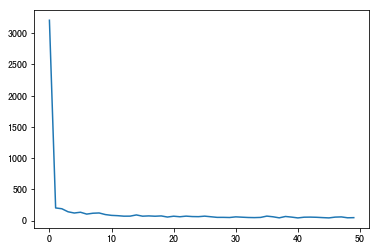

In [103]:
plt.plot(losses)

In [105]:
W1.value

array([[-8.41231704e-01, -4.17912611e-01, -9.79667968e-01,
        -9.93939844e-01, -1.20677268e+00,  1.33196830e-02,
         2.12823015e+00, -1.42477979e+00,  3.76380168e-01,
        -4.97291131e-01],
       [ 2.29352668e+00,  2.42248024e-01,  1.24560124e-02,
         9.52687374e-01, -5.12767569e-01, -3.63405898e-01,
         1.03284051e+00, -2.18890303e-01, -1.12423916e-03,
         3.39130709e-01],
       [ 1.07514523e+00,  1.23763558e+00,  9.07164709e-02,
         9.84150479e-01,  1.35108907e+00,  6.93577477e-01,
        -5.09242107e-01,  4.24469668e-01, -7.70880937e-01,
        -1.59567675e+00],
       [ 3.36424072e-03, -1.01822612e+00,  7.32448153e-03,
        -4.40168362e-03,  3.82733931e+00, -3.74574327e-01,
         7.30528197e-03, -5.67214278e-01, -2.18322328e-01,
         8.12763511e-02],
       [-3.42829125e+00,  1.11352868e+00, -1.31610337e+00,
         3.28411659e-01,  1.46576347e+00,  2.31788350e-01,
         2.99047627e+00,  8.31093900e-01, -4.06194686e-01,
        -9.

In [106]:
W2.value

array([[ 7.66479385],
       [-2.65509922],
       [ 6.10007003],
       [ 7.34485196],
       [ 6.07696602],
       [ 4.80457455],
       [ 4.86742412],
       [ 4.66231273],
       [ 6.97347865],
       [ 7.34414908]])

In [107]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [108]:
x1 = Input()

In [109]:
x1.value = X_[1]

In [117]:
y_of_x1 =  Linear(Sigmoid(Linear(x1, W1, b1)), W2, b2)

In [119]:
W1.value.shape

(13, 10)

In [124]:
def _sigmoid(x):
        return 1. / (1 + np.exp(-1 * x))

In [127]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([23.94078679])

In [129]:
y_[1]

21.6

In [118]:
y_of_x1